In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.testing import SeqIndTester
from joblib import Parallel, delayed
import matplotlib

In [2]:
sns.set(style="whitegrid",
        font_scale=1.4,
        rc={
            "lines.linewidth": 2,
#             "axes.facecolor": ".9",
            'figure.figsize': (8, 6)
        })
sns.set_palette('Set2')
matplotlib.rcParams['text.usetex'] = True

Sample data

In [6]:
global_sims = 100
sample_size = 2000
n_pairs = sample_size//2


In [7]:
num_betas = 10
betas = np.linspace(0, 0.5, num_betas)

In [8]:
def run_sim(cur_beta):
    rej_hist = list()
    sample_hist = list()
    for cur_sim in range(global_sims):
        # generate sphere data
        X = np.random.normal(size=[sample_size, 1])
        eps = np.random.normal(size=[sample_size, 1])
        Y = X * cur_beta + eps
        # initialize tester with hsic payoff
        tester = SeqIndTester()
        # RBF-kernel by default, provide kernel hypeerparameters (there is an implementation of med heuristic in utils.testing.py)
        tester.kernel_param_x = 1/4
        tester.kernel_param_y = 1/(4 * (1 + cur_beta**2))
        tester.significance_level = 0.05
        tester.payoff_style = 'hsic'
        # choose the rule for selecting betting fractions: 'mixing', 'aGRAPA' or 'ONS'
        tester.lmbd_type = 'ONS'
        # for ONS use truncation level 0.5, for aGRAPA 0.9
        tester.truncation_level = 0.5
        # process pairs and keep track of the wealth
        for cur_pair in range(1, n_pairs-1):
            tester.process_pair(X[2 * cur_pair: 2 * (cur_pair + 1)], Y[2 * cur_pair: 2 * (cur_pair + 1)],
                                X[:2 * cur_pair], Y[:2 * cur_pair])
            if tester.null_rejected:
                # account for the first pair
                rej_hist += [True]
                sample_hist += [float(cur_pair)+1]
                break
        if tester.null_rejected is False:
            rej_hist += [False]
            # if not rejected, save n_pairs for visuals
            sample_hist += [n_pairs]
    return rej_hist, sample_hist


In [9]:
all_hist = Parallel(n_jobs=-1)(delayed(run_sim)(cur_beta)
                               for cur_beta in betas)
                               
rejections, sam_sizes = zip(*all_hist)

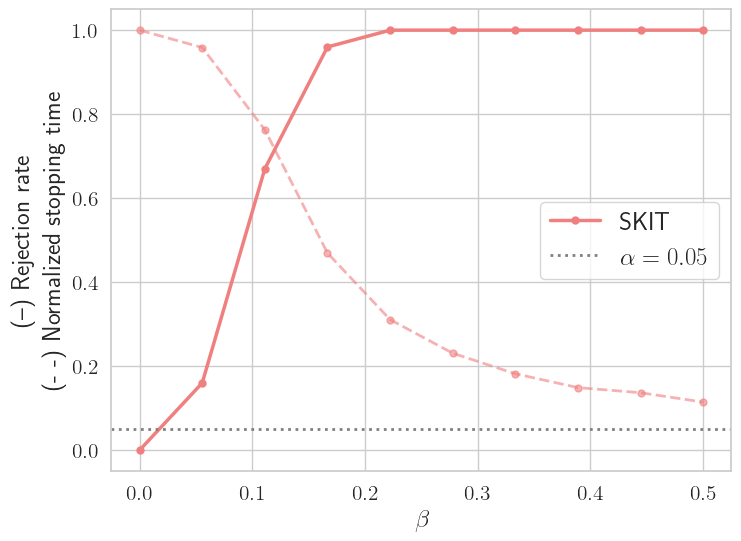

In [10]:
plt.plot(betas, np.mean(rejections, axis=1), linewidth=2.5,
         color='lightcoral',marker='o', markersize=5, label='SKIT')

plt.plot(betas, np.mean(sam_sizes, axis=1) /
         n_pairs, color='lightcoral',marker='o', markersize=5, linewidth=2, linestyle='dashed', alpha=0.6)

plt.axhline(y=0.05, label=r'$\alpha=0.05$', linestyle='dotted', linewidth=2,c='gray')
plt.xlabel(r'$\beta$', fontsize=18)
plt.ylabel(
    r'\begin{center} (--) Rejection rate \\ (- -) Normalized stopping time  \end{center}', fontsize=18)
plt.legend(loc=5, fontsize=18)
plt.show()
